In [2]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn import cluster

Number of samples:  788


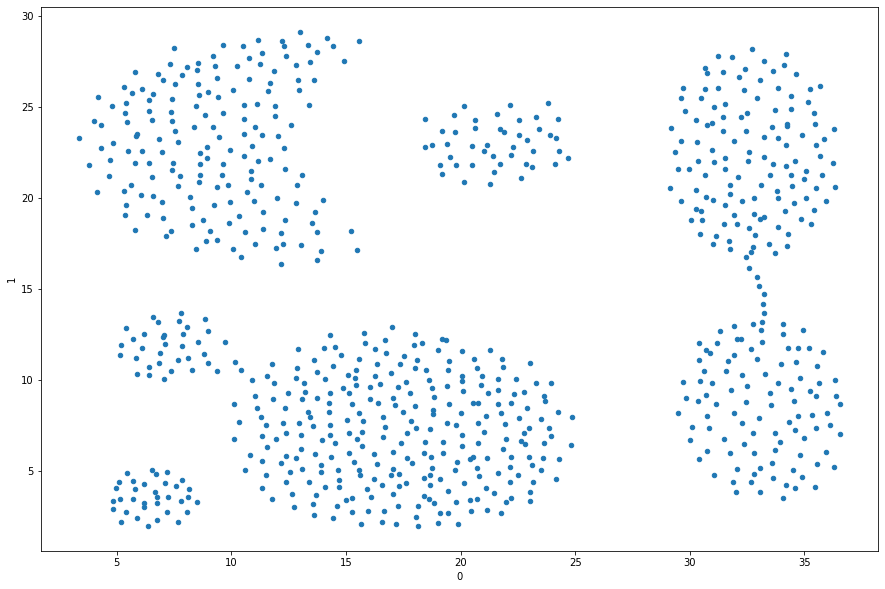

In [5]:
data = pd.read_csv('data.csv', header=None)
print('Number of samples: ', len(data))
data.plot.scatter(0, 1, figsize=(15, 10))
plt.show()

data = data.values

In [7]:
mean = data.mean()
std = data.std()
data = (data - mean) / std

In [8]:
class DBSCAN:
    def __init__(self, min_samples, eps):
        """
        Constructs DBSCAN given parameters of neighborhood

        :param min_samples: Minimum samples within eps radius to be consider as a core point
        :param eps: Radius of core point
        """
        self.min_samples = min_samples
        self.eps = eps

        self.labels = None  # '0': Haven't processed, '-1': noise, 'C': cluster number
        self.core_points = None

    def fit_predict(self, x, *args, **kwargs):
        """
        Fits the data using DBSCAN and returns labels and core points
        Order of data matter!

        Algorithm:
            1. Consider a list of points that have not been seen yet
            2. Read an arbitrary point until there is no unseen point left
            3. If there are at least ``min_samples`` points within a radius of ``eps``
                then all these points are from same cluster
            4. Expand this cluster for its all core points for all neighbors
            5. Repeat

        :param x: N-dimensional numpy array

        :return: A tuple of labels of each point and index of core points
            where label=-1 corresponds to noise data and label=N N>=1 demonstrates cluster label
        """

        self.labels = np.zeros((len(x),))
        self.core_points = np.zeros((len(x),))
        current_cluster = 1  # we use 1->inf

        for pnt in range(len(x)):
            # if self.labels[pnt] == -1 or self.labels[pnt] >= 1:
            if self.labels[pnt] == 0:
                neighbor_indices = self.__nearest_neighbors(x, x[pnt])

                if len(neighbor_indices) >= self.min_samples:
                    self.__expand(x, pnt, current_cluster)
                    current_cluster += 1
                else:  # noise/outlier scenario
                    self.labels[pnt] = -1
        return self.labels, self.core_points

    def __nearest_neighbors(self, data, point):
        """
        Finds points near to the point ``point`` within the range of ``eps``

        :param point: A point
        :param: All points

        :return: Indices of nearest neighbor points
        """
        distances = euclidean_distances(data, point.reshape(1, -1))
        neighbors = distances <= self.eps
        topk = np.argsort(distances, axis=0)
        neighbors_idx = np.max(neighbors[topk].nonzero()[0]) + 1
        return topk[:neighbors_idx].flatten()

    def __expand(self, data, point_idx, current_cluster):
        """
        Expands ``current_cluster`` using given point w.r.t. ``eps`` and ``min_samples``
        Algorithm:
            1. Get a point as the start point for ``current_cluster``
            2. Get its neighbors and go through them one by one using queue logic
            3. If the neighbor is noise, then add it to the current cluster, if it is unseen, get all its neighbors
                 then add them to the list of neighbors of original point
            4. Repeat step 2 and 3 until all points in the list of neighbors are processed.

        :param data: Whole data to be clustered
        :param point_idx: The index of a point of the current cluster as the start point for expansion
        :param current_cluster: The label of current cluster
        :return: None
        """

        self.labels[point_idx] = current_cluster
        neighbors_indices = deepcopy(self.__nearest_neighbors(data, data[point_idx]))

        while len(neighbors_indices) > 0:
            neighbor_point = neighbors_indices[0]
            neighbors_indices = np.delete(neighbors_indices, 0, 0)
            if self.labels[neighbor_point] == -1:
                self.labels[neighbor_point] = current_cluster
            elif self.labels[neighbor_point] == 0:
                self.labels[neighbor_point] = current_cluster
                neighbors_indices_neighbor_point = self.__nearest_neighbors(data, data[neighbor_point])
                if len(neighbors_indices_neighbor_point) >= self.min_samples:
                    neighbors_indices = np.concatenate((neighbors_indices, neighbors_indices_neighbor_point))
                    self.core_points[neighbor_point] = 1

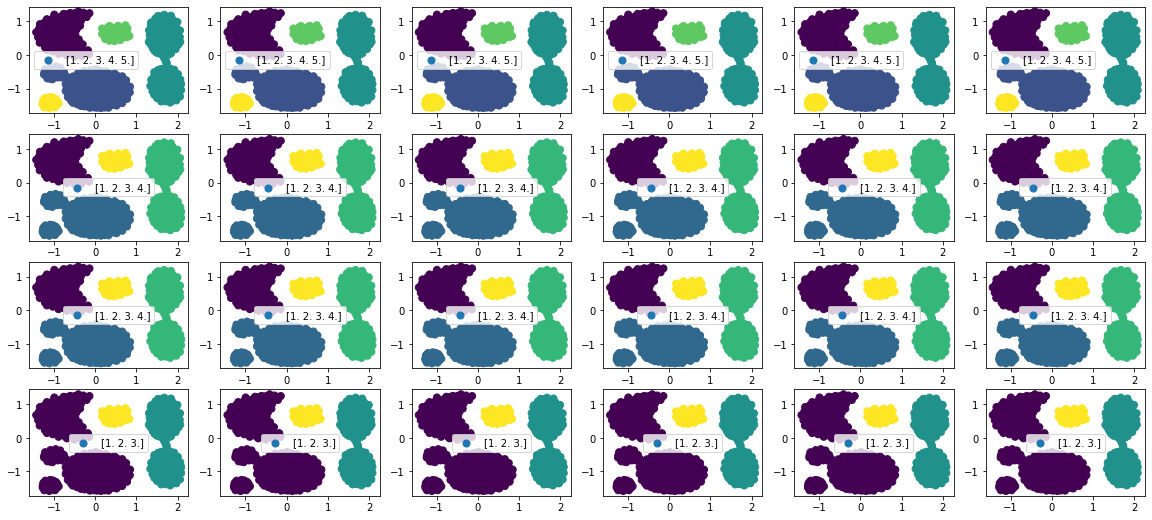

In [9]:
parameters = {'eps': [0.25, 0.3, 0.35, 0.4], 'min_samples': [3, 4, 5, 6, 7, 10]}

plt.figure(figsize=(20, 9))
i = 0
for dist in parameters['eps']:
    for min_pnt in parameters['min_samples']:
        dbscan = DBSCAN(min_samples=min_pnt, eps=dist)
        y_dbscan, _ = dbscan.fit_predict(data)
        plt.subplot(len(parameters['eps']), len(parameters['min_samples']), i+1)
        i += 1
        plt.scatter(data[:, 0], data[:, 1], c=y_dbscan, s=50, cmap='viridis', label=np.unique(y_dbscan))
        plt.legend()
plt.show()

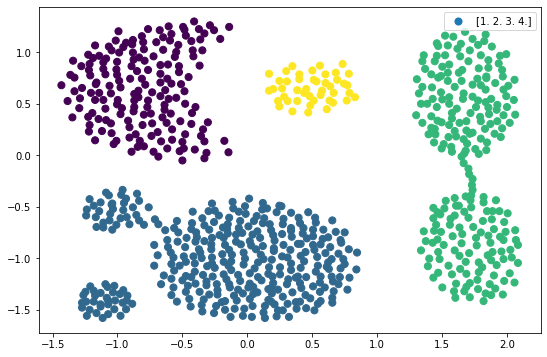

In [12]:
plt.figure(figsize=(9, 6))
dbscan = DBSCAN(min_samples=5, eps=0.3)
y_dbscan, centers = dbscan.fit_predict(data)
plt.scatter(data[:, 0], data[:, 1], c=y_dbscan, s=50, cmap='viridis', label=np.unique(y_dbscan))
plt.legend()
plt.show()